# Vectorizing and Beyond

Streamlined process for choosing vectorizer and topic modeling method, looking at similar songs by cosine similarity, and testing clustering algorithms.

In [2]:
import fletchmod
import numpy as np
from pymongo import MongoClient
from bson.objectid import ObjectId
import pprint
import pickle

Creates MongoDB collection object and loads cleaned lyrics plus song IDs.

In [3]:
client = MongoClient()
p4_db = client.proj4
lyrics_coll = p4_db.lyrics

lyrics, song_ids = fletchmod.lyrics_from_db(lyrics_coll, 'Lyrics_clean')

## Vectorizing and Topic Modeling

The following object allows for rapid testing of vectorizer, topic model, and associated parameters. The last batch of parameters and fitted models are stored as part of the object, and will remain as such unless input is provided that overwrites -- leaving a field blank when prompted will use the last value provided.

I probably cycled through a hundred combinations; the following is the one I stuck with for presentation.

In [4]:
trial = fletchmod.TrySomeStuff(lyrics)

-- VECTORIZER --

Choose your vectorizer type, CV (1) / TFIDF (2):
> 2
Max features (~7000 words post-tokenizer):
> 2000
Max document frequency (0-1):
> 0.5
Max n-gram length:
> 1

-- TOPIC MODEL --

Choose your topic model, LSA (1) / NMF (2):
> 2
Number of components:
> 20

-- SPAWNING MODELS --

VECTORIZER:

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=2000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function spacy_tokenizer at 0x1198fd1e0>, use_idf=True,
        vocabulary=None)

TOPIC MODEL:

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=20, random_state=23, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)

Hit enter to con

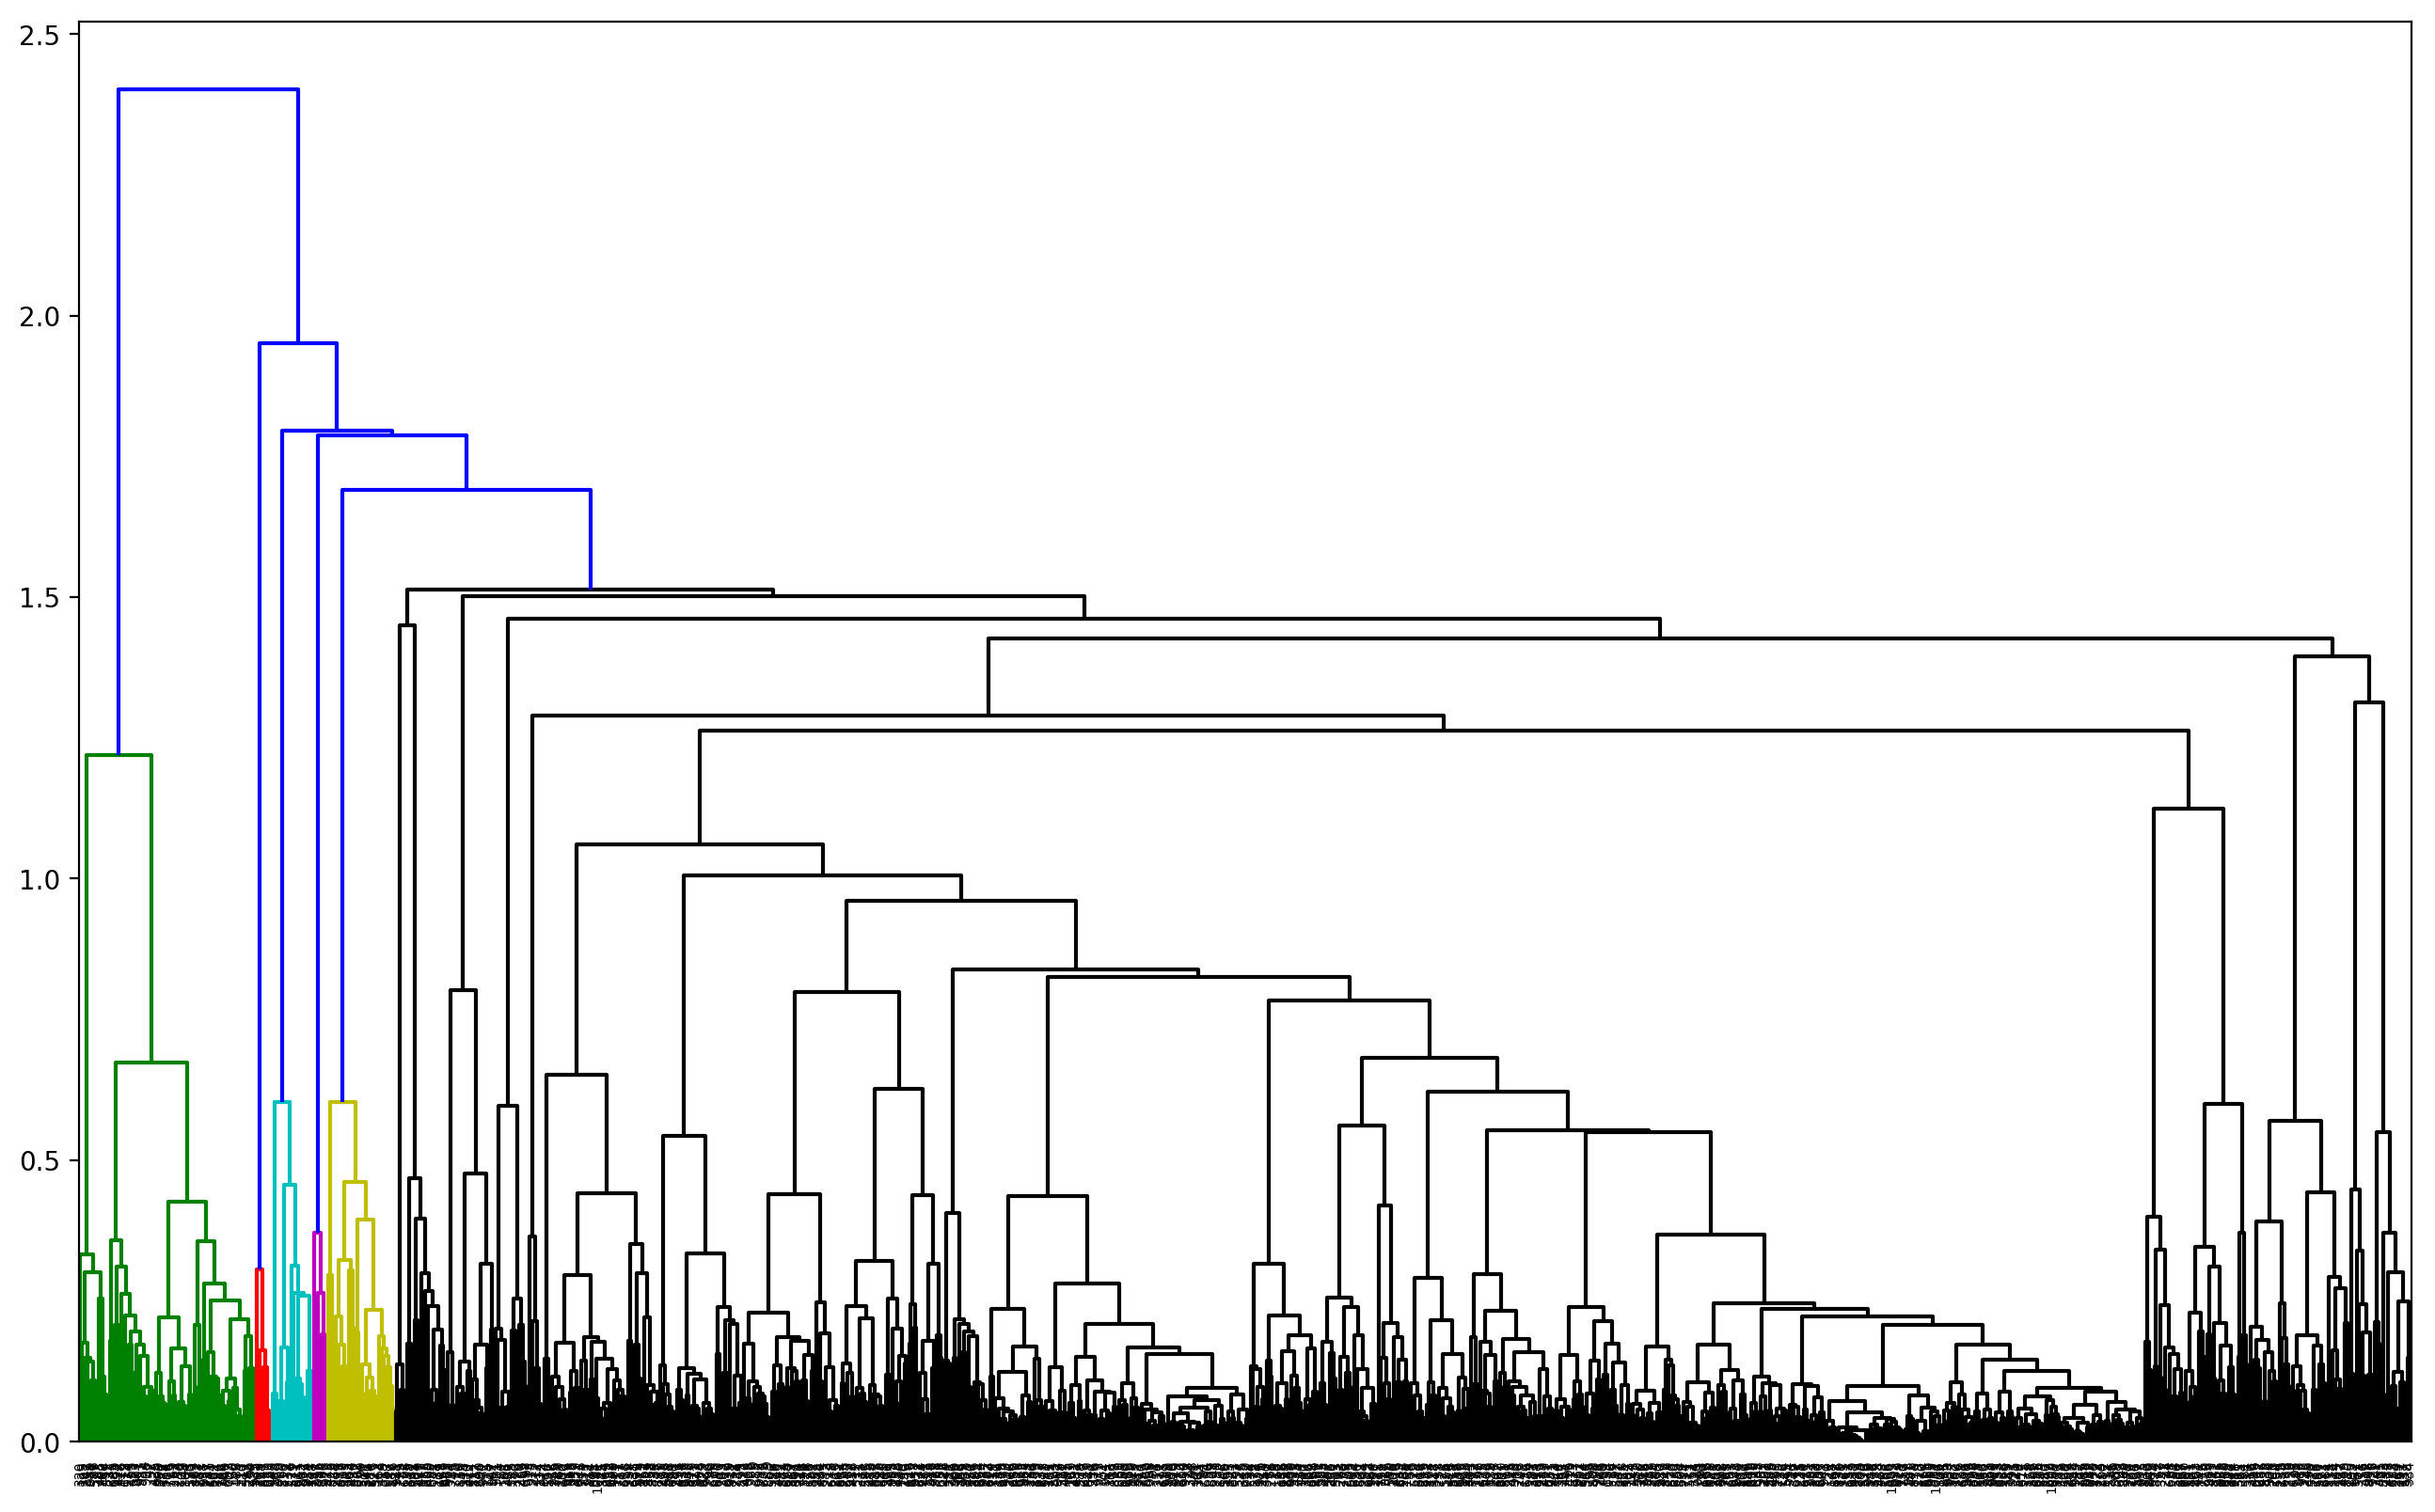


Pickle current object? (y/n)
> n

Go again? (y/n)
> n


In [5]:
# to loop continuously:
# trial.loop()
# to make one pass:
trial.loop()

## Find Similar Songs to Relevant Ones

The following songs represent the trend I'm investigating. Using NearestNeighbors and cosine similarity, I'll see what the other most similar songs are in the topic space established.

In [5]:
# Say It Loud, War, Smiling Faces Sometimes, Back Stabbers
example_ids = ['59f903150f3e05a46c01d90d',
               '59f903150f3e05a46c01d980',
               '59f903150f3e05a46c01d9ed',
               '59f903150f3e05a46c01da66'
              ]

If not using the last version of the object generated above:

In [3]:
with open('../data/tfidf_750_025_1_nmf_16.pkl', 'rb') as pf:
    trial = pickle.load(pf)

In [4]:
trial.print_models()


VECTORIZER:

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=750, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function spacy_tokenizer at 0x122c691e0>, use_idf=True,
        vocabulary=None)

TOPIC MODEL:

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=16, random_state=23, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)


In [8]:
# print most similar songs with cosine similarities
for song_id in example_ids:
    sim_songs, dists, ixs = fletchmod.get_similar(song_id, song_ids, trial.topic_data, n_sim=10)
    fletchmod.display_sim_songs(song_id, sim_songs, dists)


Similar to Say It Loud  Im Black And Im Proud by James Brown:
Monster Mash - Bobby Boris Pickett And The Cryptkickers (0.886)
Mercy Mercy Me The Ecology - Marvin Gaye (0.864)
Fight The Power - The Isley Brothers (0.847)
Brother Louie - Stories (0.845)
Long Train Runnin - The Doobie Brothers (0.845)
Smokin In The Boys Room - Brownsville Station (0.835)
The Cover Of The Rolling Stone - Dr Hook  The Medicine Show (0.834)
Jambalaya On The Bayou - Blue Ridge Rangers (0.83)
Yes Im Ready - Barbara Mason (0.823)
Philadelphia Freedom - Elton John (0.815)

Similar to War by Edwin Starr:
Youre No Good - Linda Ronstadt (0.975)
Good Vibrations - The Beach Boys (0.969)
Youve Lost That Lovin Feelin - The Righteous Brothers (0.963)
Gimme Gimme Good Lovin - Crazy Elephant (0.96)
My Baby Loves Lovin - White Plains (0.959)
Natural High - Bloodstone (0.958)
Easy Loving - Freddie Hart (0.957)
Lovin You - Minnie Riperton (0.957)
Lets Live For Today - The Grass Roots (0.956)
Gimme Some Lovin - The Spencer D

I cannot figure out why "Monster Mash" comes up as being the most similar to "Say It Loud," though the most similar songs for the other three have far more significant cosine similarieties. Add outlier detection to the wish list.

In [22]:
lyrics_coll.find_one({"_id": ObjectId('59f903150f3e05a46c01d90d')})['Lyrics_clean']

'uh with your bad self say it louder im black and im proud say it louder im black and im proud look here some people say we got a lot of malice some say its a lotta nerve i say we wont quit moving lit we get what we deserve eve been booked and eve been scorned eve been treated bad talked about as just as sure as youre born but just as sure as it take two eyes to make a pair huh brother we cant quit until we get our share say it loud im black and im proud say it loud im black and im proud one more time say it loud im black and im proud huh ive worked on jobs with my feet and my hands but all the work i did was for the other man and now we demands a chance to do things for ourselves we tired of beating our heads against the wall and working for someone else say it loud im black and im proud say it loud im black and im proud say it loud im black and im proud say it loud im black and im proud wee wee youre killing me alright uh youre out of sight alright so tough youre tough enough wee uh 

In [26]:
lyrics_coll.find_one({"Song": "monster mash"})['Lyrics_clean']

'i was working in the lab late one night when my eyes beheld an eerie sight for my monster from his slab began to rise and suddenly to my surprise he did the mash he did the monster mash the monster mash it was a graveyard smash he did the mash it caught on in a flash he did the mash he did the monster mash from my laboratory in the castle east to the master bedroom where the vampires feast the ghouls all came from their humble abodes to get a jolt from my electrodes they did the mash they did the monster mash the monster mash it was a graveyard smash they did the mash it caught on in a flash they did the mash they did the monster mash the zombies were having fun the party had just begun the guests included wolf man dracula and his son the scene was rocking all were digging the sounds or on chains backed by his baying hounds the coffin bangers were about to arrive with their vocal group the crypt kicker five they played the mash they played the monster mash the monster mash it was a gr

## Clustering

Using either the trial object in its last configuration, or whichever one was retrieved from a pickle, the following allows me to try a couple different clustering algorithms, specifying number of clusters and other parameters as necessary. Decisions are guided by the dendrogram, which can be reprinted from the object as such: 

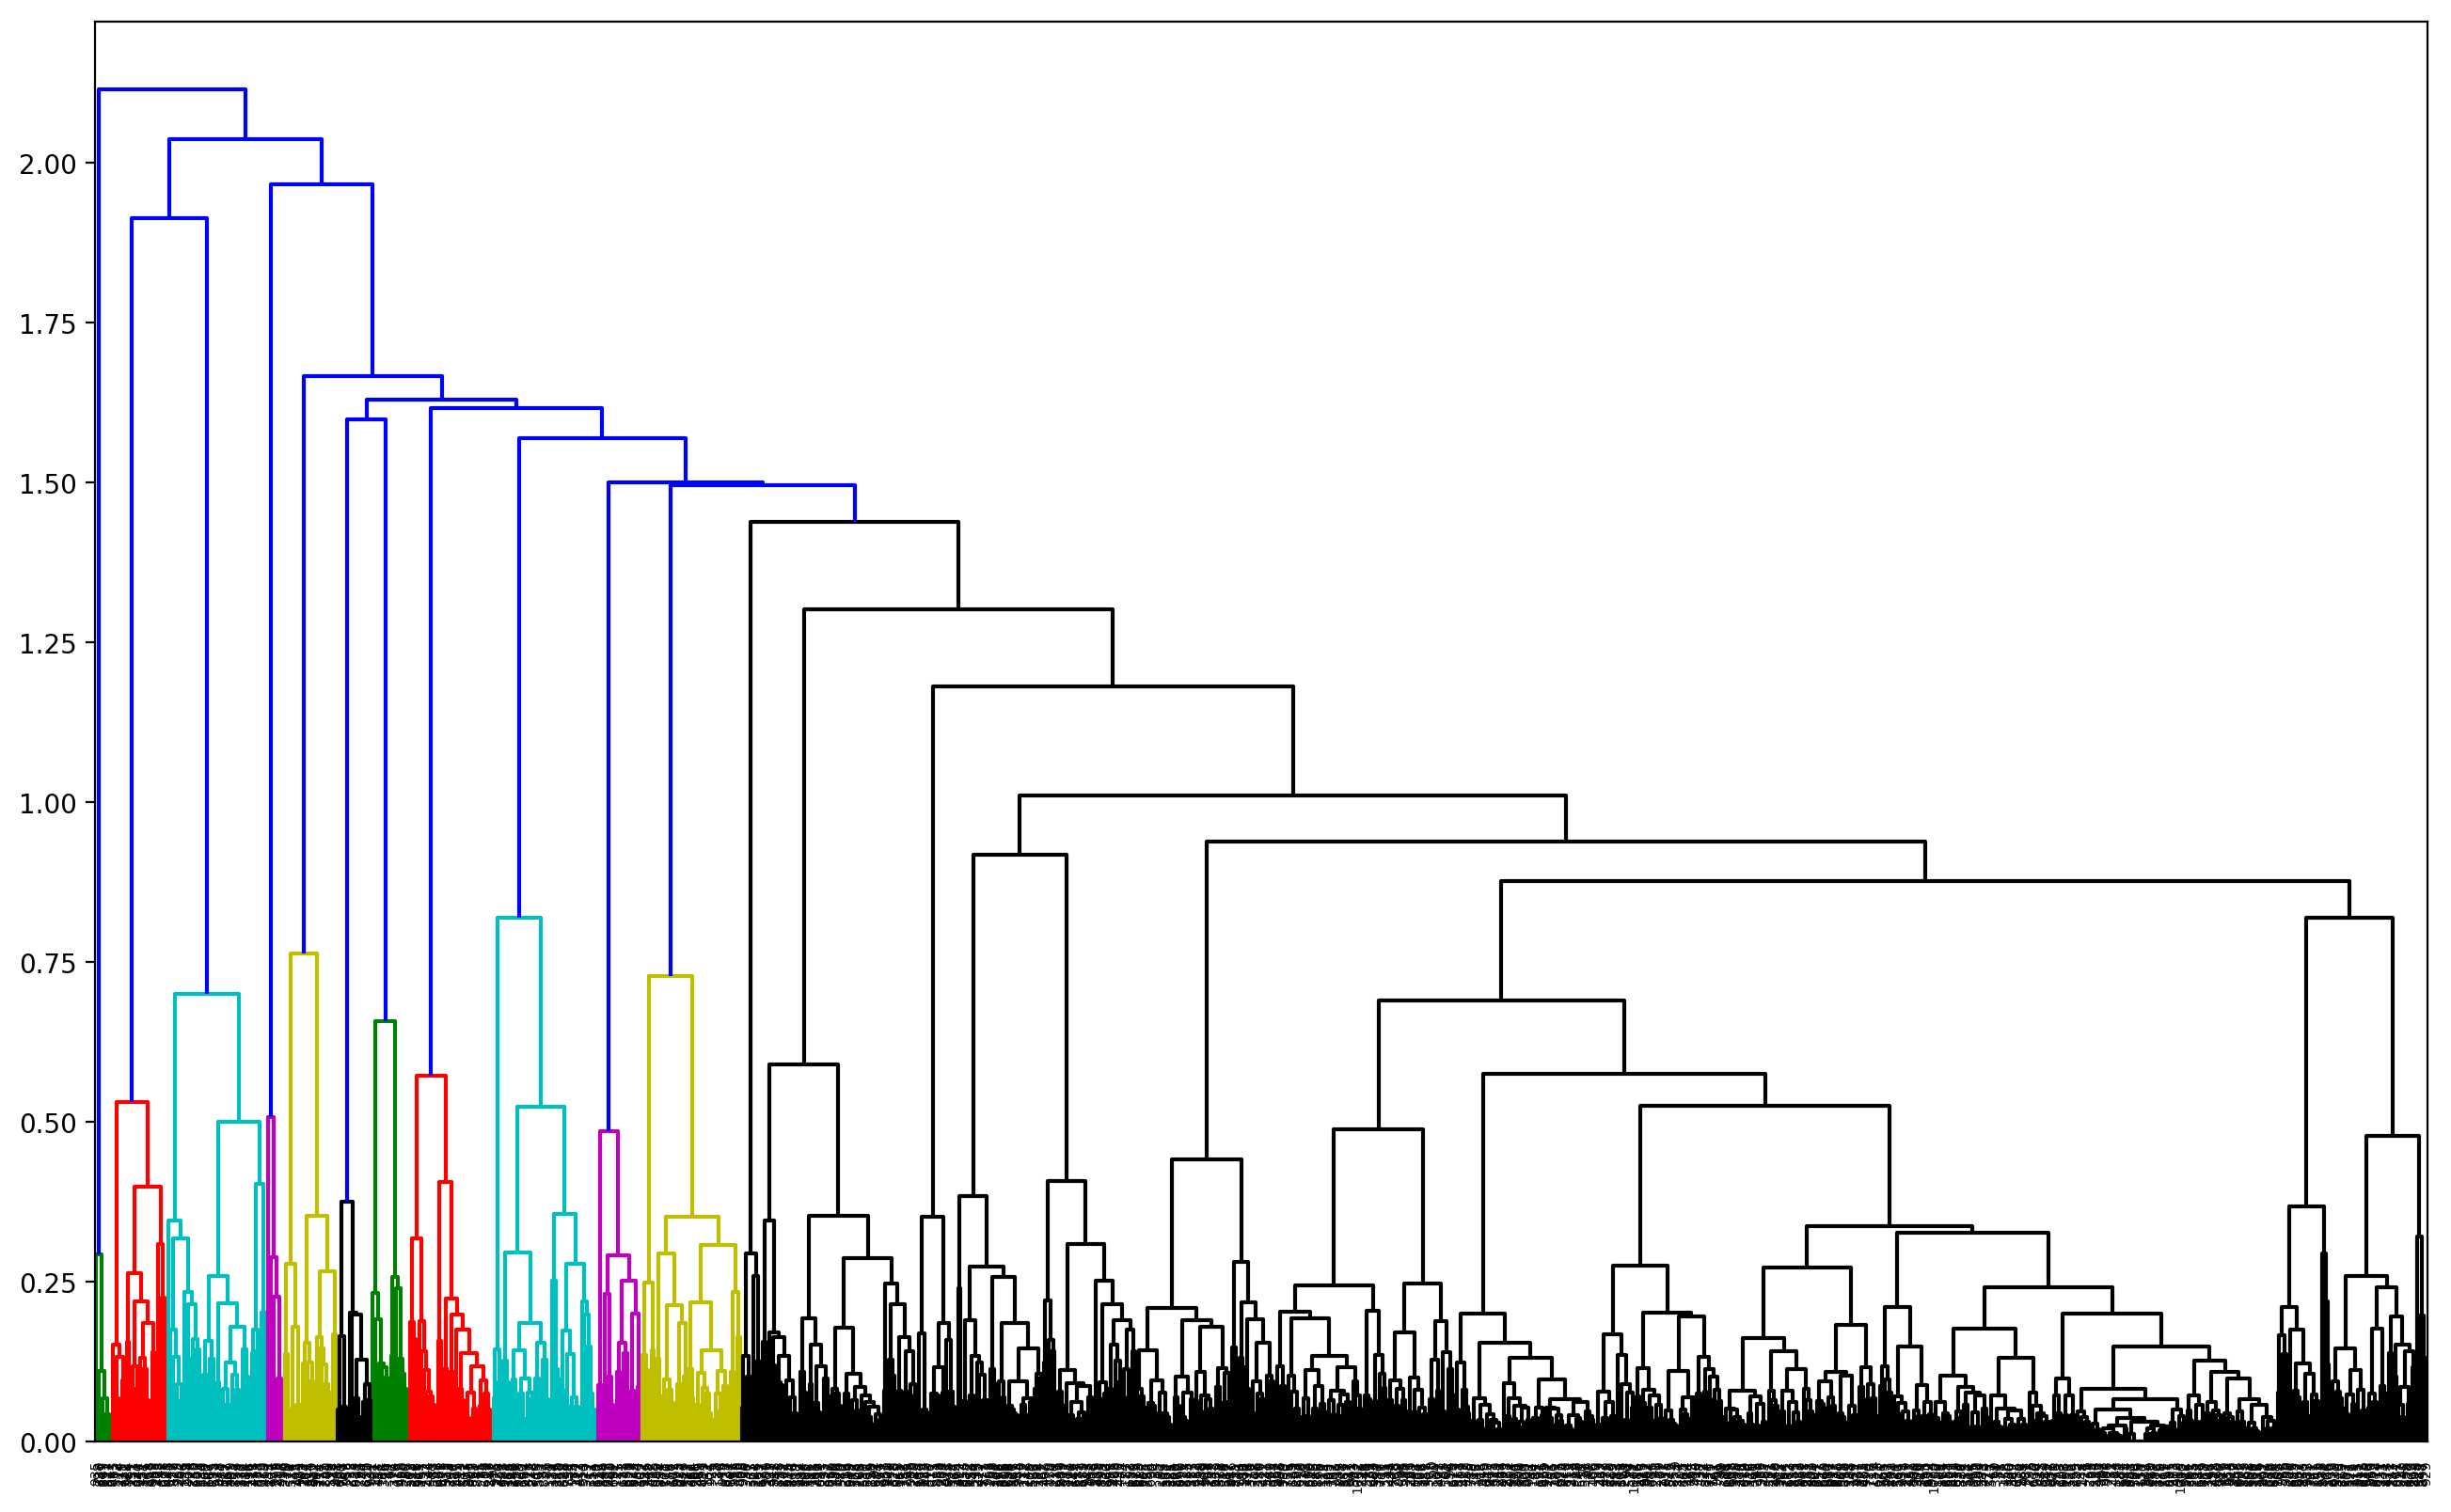

In [9]:
trial.draw_dendro(img_name='tfidf_nmf_dendro')

First attempts at finding clusters while using Count Vectorizer yielded very few meaningful results, despite producing promising-looking dendrograms. With the TFIDF/NMF settings above, some smaller clusters start to form around 'dance,' 'boogie', 'lady', and 'girl', though nothing picks out any of the topics I had originally been trying to track.

In [11]:
trial_clusters = fletchmod.TrySomeClusters(trial.topic_data, song_ids)

In [12]:
# run to cycle through cluster range
trial_clusters.loop()


-- CLUSTERING PARAMETERS --

Algorithm, Agg (1) / DBSCAN (2):
> 1
Number of clusters:
> 7
Linkage method, ward (1), complete (2), average (3):
> 1

-- FIT AND PREDICT --

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=7,
            pooling_func=<function mean at 0x107264268>)

Silhouette score: 0.388355132159

Members per Cluster:
*   Cluster 0: 869
*   Cluster 1: 24
*   Cluster 2: 31
*   Cluster 3: 7
*   Cluster 4: 7
*   Cluster 5: 43
*   Cluster 6: 23

Show text samples from each cluster? (y/n):
> y

Cluster 0:

Title: Lets Stay Together
i im so in love with you whatever you want to do is all right with me cause you make me feel so brand new and i want to spend my life with you let me say that since baby since eve been together loving you forever is what i need oh let me be the one you come running to ill never be untrue oh lets lets stay together loving you whether whether times are goo

> n

Go again? (y/n)
> n


Cycles through a specified range of cluster numbers and displays the total silhouette score for each to get a rough idea of how coherent these clusters might be.

In [14]:
trial_clusters.agg_cluster_range()

Minimum number of clusters:
> 2
Maximum number of clusters:
> 13
Linkage method, ward (1), complete (2), average (3):
> 1
Clusts	Silhouette Score:
2	0.659409973060894
3	0.3778009991323898
4	0.38958348551124466
5	0.36830899665309424
6	0.3769074091353923
7	0.3883551321589954
8	0.3308385578258783
9	0.33864962921068403
10	0.31019335943965815
11	0.3248836120716241
12	0.31837650269740325
13	0.32868227845088077
